# find all of Katie's data

In [1]:
import os
indir='/home/krothamel/projects/Kris_Katie'
# single reps 
overlap_beds = [f for f in os.listdir(indir) 
         if f.startswith('overlap')]

In [2]:
overlap_beds

['overlap_PCF11_df.bed',
 'overlap_AIMP1_df.bed',
 'overlap_DLD_df.bed',
 'overlap_DARS_df.bed',
 'overlap_DLST_df.bed',
 'overlap_RPS5_df.bed',
 'overlap_KARS_df.bed']

In [3]:
all_katis_beds = [os.path.join(indir,f) for f in overlap_beds]

In [4]:
# this is an internal package I wrote for easy access to encode data 
from pybedtools import BedTool
import matplotlib.pyplot as plt
plt.style.use('seaborn-muted')
import sys
import pandas as pd
import numpy as np
master_df = pd.read_csv('encode_data.csv')
master_df['idr'] # these are all the IDR peaks!

0      /projects/ps-yeolab5/encode/EVN_eCLIP_analysis...
1      /projects/ps-yeolab5/encode/EVN_eCLIP_analysis...
2      /projects/ps-yeolab5/encode/EVN_eCLIP_analysis...
3      /projects/ps-yeolab5/encode/EVN_eCLIP_analysis...
4      /projects/ps-yeolab5/encode/EVN_eCLIP_analysis...
                             ...                        
330    /projects/ps-yeolab5/encore/processing/encore_...
331    /projects/ps-yeolab5/encore/processing/encore_...
332    /projects/ps-yeolab5/encore/processing/encore_...
333    /projects/ps-yeolab5/encore/processing/encore_...
334    /projects/ps-yeolab5/encore/processing/encore_...
Name: idr, Length: 335, dtype: object

## Calculate Jaccard for rG4

In [5]:
# to find what transcript those intersecting peaks are in:
# you need to load the trascript coordinates from gencode (i have it parsed already here)
transcripts = BedTool('/home/hsher/gencode_coords/gencode.v33.transcript.gff3')

def get_jaccard(bed1,bed2, return_transcript = False, transcripts = transcripts):
    '''
    input 2 bed files, return jaccard index to represent how they overlap
    if return_transcript is true, return BedTool object of transcript gff coords
    
    '''
    # select IDRs and G4 in UTR only
    
    
    intersect_peaks = bed1.intersect(bed2, s = True, u = True)
    intersect = len(intersect_peaks)
    not_one = len(bed2)-intersect
    not_two = len(bed1)-intersect
    
    jaccard = intersect/(intersect+not_one+not_two)
    
    #### return transcripts that has the intersecting peaks!
    if return_transcript:
        # find what transcript is
        

        # then, to find what transcripts the peaks are in (s = stranded, u = unique)
        transcripts_with_peaks = transcripts.intersect(intersect_peaks, s = True, u = True).saveas()

        return jaccard, transcripts_with_peaks
    else:
        
        return jaccard

## An example of the above function

In [6]:
# let's try out 1 bed files
katie_dars = BedTool('/home/wjin/projects/CLIP_seq/Kris_Katie/Data/full_IDR_pipeline_2inputs_example11/results/DARS_A.vs.DARS_B.bed')
encode_gars = BedTool(master_df.loc[master_df['RBP']=='GARS', 'idr'].iloc[0])

In [7]:
jaccard, transcript_with_intersect_bed = get_jaccard(katie_dars,encode_gars, return_transcript = True)

In [8]:
len(transcript_with_intersect_bed)

43

In [9]:
all_transcripts_attrs = []
for t in transcript_with_intersect_bed:
    all_transcripts_attrs.append([t.attrs['gene_name'], t.attrs['transcript_type'], t.attrs['gene_id']])


In [10]:
pd.DataFrame(all_transcripts_attrs).to_csv('FILENAME.csv')

## Let loop over all encode proteins!

In [11]:
# get the rbp name from katie's rbp
rbps = [os.path.basename(f).split('_')[1] for f in all_katis_beds]

In [12]:
rbps

['PCF11', 'AIMP1', 'DLD', 'DARS', 'DLST', 'RPS5', 'KARS']

In [13]:
all_rbp_data = master_df['idr']

In [14]:
def fix_bad_strand(bedtool_obj):
    ''' a very bad approach trying to fix bed files that are not in the standard format :('''
    df = bedtool_obj.to_dataframe()
    df['empty']='.'
    df['empty2']='.'
    return BedTool.from_dataframe(df[['chrom', 'start', 'end', 'empty', 'empty2', 'name']])

In [15]:
import warnings
all_dist = []
# # let's loop over all katie's RBP
for katie_dir, query_rbp_name in zip(all_katis_beds, rbps):
    jaccard_to_katie = {}
    
    katie_rbp = BedTool(katie_dir)
    if katie_rbp[0].strand == '.':
        warnings.warn('KATIE! strand needs to be in the 6th column!')
        katie_rbp = fix_bad_strand(katie_rbp)
    
    # calculate encode
    for index, row in master_df.iterrows():
        try:
            encode_rbp = row['uid']+'_'+ row['RBP'] # make a unique id for each RBP
            encode_bed = BedTool(row['idr'])

            jaccard_to_katie[encode_rbp] = get_jaccard(katie_rbp, encode_bed)
        except Exception as e:
            print(e) # some of the encode data are not complete yet therefore it might elicit some error
    # calculate those from katie, also compare internally
    for rbp, path in zip(rbps, all_katis_beds):
        another_katie_rbp = BedTool(path)
        if another_katie_rbp[0].strand =='.':
            another_katie_rbp = fix_bad_strand(another_katie_rbp)
        jaccard_to_katie[f'katie_{rbp}'] = get_jaccard(katie_rbp, another_katie_rbp)
    
    # save
    all_dist.append(pd.Series(jaccard_to_katie, name = query_rbp_name))

/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: KATIE! strand needs to be in the 6th column!
  if __name__ == '__main__':


File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4038_CLIP1_rep1.vs.4038_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4053_CLIP1_rep1.vs.4053_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch14_IDR/results/4099_CLIP1_rep1.vs.4099_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch16_IDR/results/4093_CLIP1_rep1.vs.4093_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master__IDR/results/4094_CLIP1_rep1.vs.4094_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch17_IDR/results/4096_CLIP1_rep1.vs.4096_CLIP2_rep2.bed" does not exist
File "/projects

/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: KATIE! strand needs to be in the 6th column!
  if __name__ == '__main__':


File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4038_CLIP1_rep1.vs.4038_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4053_CLIP1_rep1.vs.4053_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch14_IDR/results/4099_CLIP1_rep1.vs.4099_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch16_IDR/results/4093_CLIP1_rep1.vs.4093_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master__IDR/results/4094_CLIP1_rep1.vs.4094_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch17_IDR/results/4096_CLIP1_rep1.vs.4096_CLIP2_rep2.bed" does not exist
File "/projects

/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: KATIE! strand needs to be in the 6th column!
  if __name__ == '__main__':


File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4038_CLIP1_rep1.vs.4038_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4053_CLIP1_rep1.vs.4053_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch14_IDR/results/4099_CLIP1_rep1.vs.4099_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch16_IDR/results/4093_CLIP1_rep1.vs.4093_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master__IDR/results/4094_CLIP1_rep1.vs.4094_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch17_IDR/results/4096_CLIP1_rep1.vs.4096_CLIP2_rep2.bed" does not exist
File "/projects

/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: KATIE! strand needs to be in the 6th column!
  if __name__ == '__main__':


File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4038_CLIP1_rep1.vs.4038_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4053_CLIP1_rep1.vs.4053_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch14_IDR/results/4099_CLIP1_rep1.vs.4099_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch16_IDR/results/4093_CLIP1_rep1.vs.4093_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master__IDR/results/4094_CLIP1_rep1.vs.4094_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch17_IDR/results/4096_CLIP1_rep1.vs.4096_CLIP2_rep2.bed" does not exist
File "/projects

/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: KATIE! strand needs to be in the 6th column!
  if __name__ == '__main__':


File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4038_CLIP1_rep1.vs.4038_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4053_CLIP1_rep1.vs.4053_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch14_IDR/results/4099_CLIP1_rep1.vs.4099_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch16_IDR/results/4093_CLIP1_rep1.vs.4093_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master__IDR/results/4094_CLIP1_rep1.vs.4094_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch17_IDR/results/4096_CLIP1_rep1.vs.4096_CLIP2_rep2.bed" does not exist
File "/projects

/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: KATIE! strand needs to be in the 6th column!
  if __name__ == '__main__':


File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4038_CLIP1_rep1.vs.4038_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4053_CLIP1_rep1.vs.4053_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch14_IDR/results/4099_CLIP1_rep1.vs.4099_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch16_IDR/results/4093_CLIP1_rep1.vs.4093_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master__IDR/results/4094_CLIP1_rep1.vs.4094_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch17_IDR/results/4096_CLIP1_rep1.vs.4096_CLIP2_rep2.bed" does not exist
File "/projects

/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: KATIE! strand needs to be in the 6th column!
  if __name__ == '__main__':


File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4038_CLIP1_rep1.vs.4038_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch11a_IDR/results/4053_CLIP1_rep1.vs.4053_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch14_IDR/results/4099_CLIP1_rep1.vs.4099_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch16_IDR/results/4093_CLIP1_rep1.vs.4093_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master__IDR/results/4094_CLIP1_rep1.vs.4094_CLIP2_rep2.bed" does not exist
File "/projects/ps-yeolab5/encore/processing/encore_master_IDR_hg38/results/encore_master_batch17_IDR/results/4096_CLIP1_rep1.vs.4096_CLIP2_rep2.bed" does not exist
File "/projects

In [16]:
# conver to dataframe 
df = pd.DataFrame(all_dist)

In [17]:
df.head()

,203_HNRNPC,204_RBFOX2,205_IGF2BP1,206_HNRNPK,209_SRSF7,211_IGF2BP3,215_TIA1,216_SRSF9,218_TRA2A,220_IGF2BP1,...,4214_PARP,4215_NSUN2,4221_TIAL1,katie_PCF11,katie_AIMP1,katie_DLD,katie_DARS,katie_DLST,katie_RPS5,katie_KARS
PCF11,0.0,0.000126,0.001018,0.000162,0.004494,0.00037,0.0,0.000000,0.000000,0.000487,...,0.000000,0.000000,0.000000,1.000000,0.029810,0.007797,0.007485,0.029299,0.001558,0.032836
AIMP1,0.0,0.002578,0.001895,0.000000,0.004104,0.00000,0.0,0.000000,0.000000,0.000666,...,0.039535,0.020806,0.002666,0.018767,1.000000,0.014205,0.009843,0.031847,0.001723,0.014085
DLD,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000371,0.005837,0.014205,1.000000,0.084337,0.118785,0.002467,0.016580
DARS,0.0,0.000000,0.000000,0.000000,0.001548,0.00000,0.0,0.000000,0.007105,0.000000,...,0.046512,0.002874,0.000540,0.004478,0.011834,0.071429,1.000000,0.058491,0.002416,0.061625
DLST,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000982,0.000000,0.000165,...,0.026971,0.027127,0.000703,0.025381,0.041801,0.106557,0.062500,1.000000,0.003431,0.031630


In [18]:
df.shape

(7, 335)

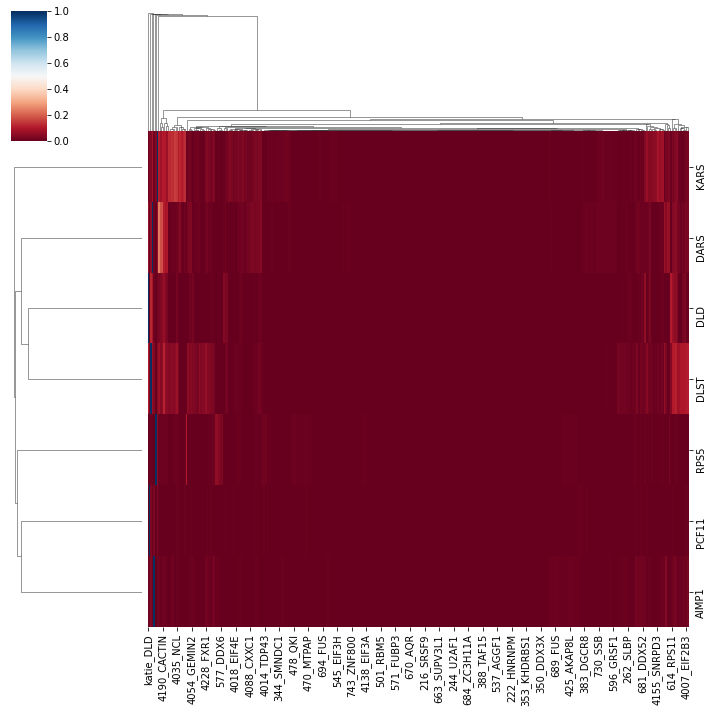

In [19]:
import seaborn as sns
# we can add annotation to functions and compelxes on the side if you want :)
sns.clustermap(df, cmap = 'RdBu')

# Only showing the network RBPs

In [20]:
# read the list that katie is interested in 
network_rbp = pd.read_csv('RBPsinNetwork.csv', header = None)[0].to_list()


In [21]:
network_rbp

['UBAP2L',
 'DCP2',
 'EIF4E',
 'PAN2',
 'PARN',
 'BUD13',
 'CHTOP',
 'CSTF2',
 'SF1',
 'U2AF2',
 'WBP11',
 'XPO5',
 'SYMPK',
 'TIA1',
 'EXOSC10',
 'RPLP0',
 'RPS5',
 'LSM7',
 'CACTIN',
 'HNRNPC',
 'SF3A2',
 'CSTF2T',
 'RPS3',
 'DDX3X',
 'PRPF3',
 'TAF15',
 'LIN28B',
 'POLR2A',
 'GPKOW',
 'ALYREF',
 'SNU13',
 'EXOSC2',
 'THOC1',
 'SNRNP200',
 'SF3B4',
 'SNRPA1',
 'SNRPC',
 'SNRPD3',
 'RPS2',
 'IGF2BP2',
 'FYTTD1',
 'EIF4G2',
 'HNRNPL',
 'CPSF7',
 'LARP7',
 'MFAP1',
 'NUP35',
 'RBM8A',
 'EXOSC9',
 'PCF11',
 'SRSF4',
 'SRSF5',
 'DGCR8',
 'EIF3A',
 'UPF2',
 'SRSF1',
 'CNOT2',
 'RPL23A',
 'RPS24',
 'SART1',
 'CASC3',
 'IGF2BP1',
 'PRPF8',
 'RBM22',
 'PTBP1',
 'POLR2A_pSer2',
 'PRP16',
 'EWSR1',
 'RBFOX2',
 'XRN1',
 'POLR2A_pSer7',
 'MSI2',
 'METTL3',
 'POLR2A_pSer5',
 'RPL18',
 'PUM2',
 'AASDHPPT',
 'AASS',
 'ABI2',
 'ACIN1',
 'ACOT9',
 'ACTB',
 'ACTC1;ACTA2;ACTG2;ACTA1',
 'ACTG1',
 'ACTL6A',
 'ACTR5',
 'ACTR8',
 'ADD1',
 'ADD2',
 'ADD3',
 'AFF4',
 'AGAP3',
 'AGK',
 'AHNAK',
 'AIMP1',
 'AIM

In [22]:
# figure out its encode header, they need to be in this format
df.columns

Index(['203_HNRNPC', '204_RBFOX2', '205_IGF2BP1', '206_HNRNPK', '209_SRSF7',
       '211_IGF2BP3', '215_TIA1', '216_SRSF9', '218_TRA2A', '220_IGF2BP1',
       ...
       '4214_PARP', '4215_NSUN2', '4221_TIAL1', 'katie_PCF11', 'katie_AIMP1',
       'katie_DLD', 'katie_DARS', 'katie_DLST', 'katie_RPS5', 'katie_KARS'],
      dtype='object', length=335)

In [23]:
# list comprehension
network_columns = [col for col in df.columns if col.split('_')[1] in network_rbp]

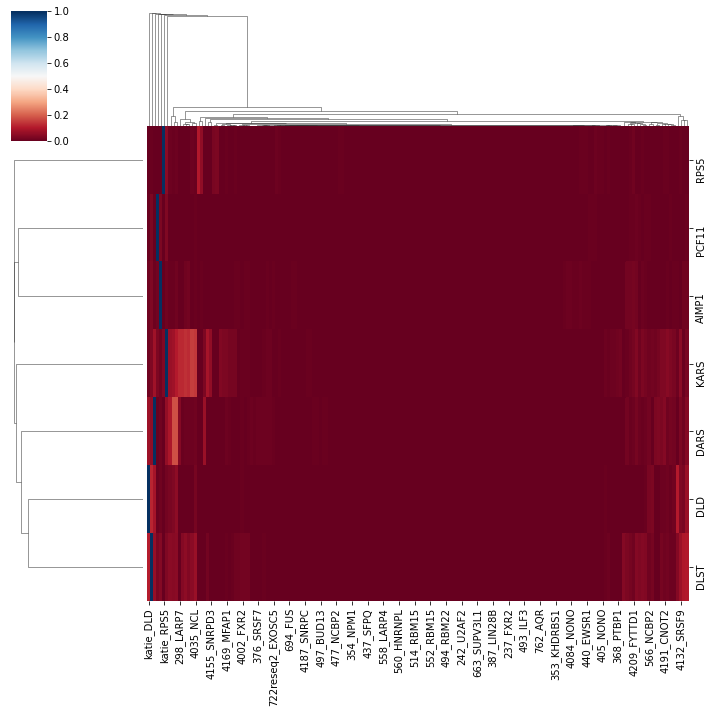

In [24]:
import seaborn as sns
# we can add annotation to functions and compelxes on the side if you want :)
sns.clustermap(df[network_columns], cmap = 'RdBu')

In [25]:
df.to_csv('jaccard.csv')